In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import math
import seaborn as sns
import time

from kan_convolutional.KANLinear import KANLinear
from kan_convolutional.KANConv import KAN_Convolutional_Layer
from kan_convolutional import convolution 


import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Define the dataset class
class Malimg(Dataset):
    def __init__(self, root_dirs, transform=None):
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.class_names = []

        for root_dir in root_dirs:
            for label, subfolder in enumerate(os.listdir(root_dir)):
                subfolder_path = os.path.join(root_dir, subfolder)
                if os.path.isdir(subfolder_path):
                    if subfolder not in self.class_names:
                        self.class_names.append(subfolder)
                    label = self.class_names.index(subfolder)
                    for img_file in os.listdir(subfolder_path):
                        if img_file.endswith('.jpg'):
                            self.image_files.append(os.path.join(subfolder_path, img_file))
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

    def get_class_names(self):
        return self.class_names

# Initialize the dataset
root_dirs = [
    "C:\\Users\\Anurag Dutta\\Desktop\\Essentials\\Research\\virus_mnist\\mnist"
]

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = Malimg(root_dirs=root_dirs, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model class
class SuperConvolutionalKAN(nn.Module):
    def __init__(self):
        super(SuperConvolutionalKAN, self).__init__()

        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 25, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))

        self.flatten = nn.Flatten()

        self.kan1 = KANLinear(
            in_features=6400,
            out_features=256,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1]
        )

        self.kan2 = KANLinear(
            in_features=256,
            out_features=10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1]
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.maxpool(x)
        
        x = self.flatten(x)

        x = self.kan1(x)

        x = self.kan2(x)
        
        x = F.log_softmax(x, dim=1)

        return x
    
model = SuperConvolutionalKAN()
model.load_state_dict(torch.load('super_kan_c_malware_classifier_64x64.pth'))
model.eval()

# Evaluate the model
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Compute metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1 Score: {f1:.4f}')

Validation Accuracy: 0.9790
Validation Precision: 0.9764
Validation Recall: 0.9662
Validation F1 Score: 0.9701


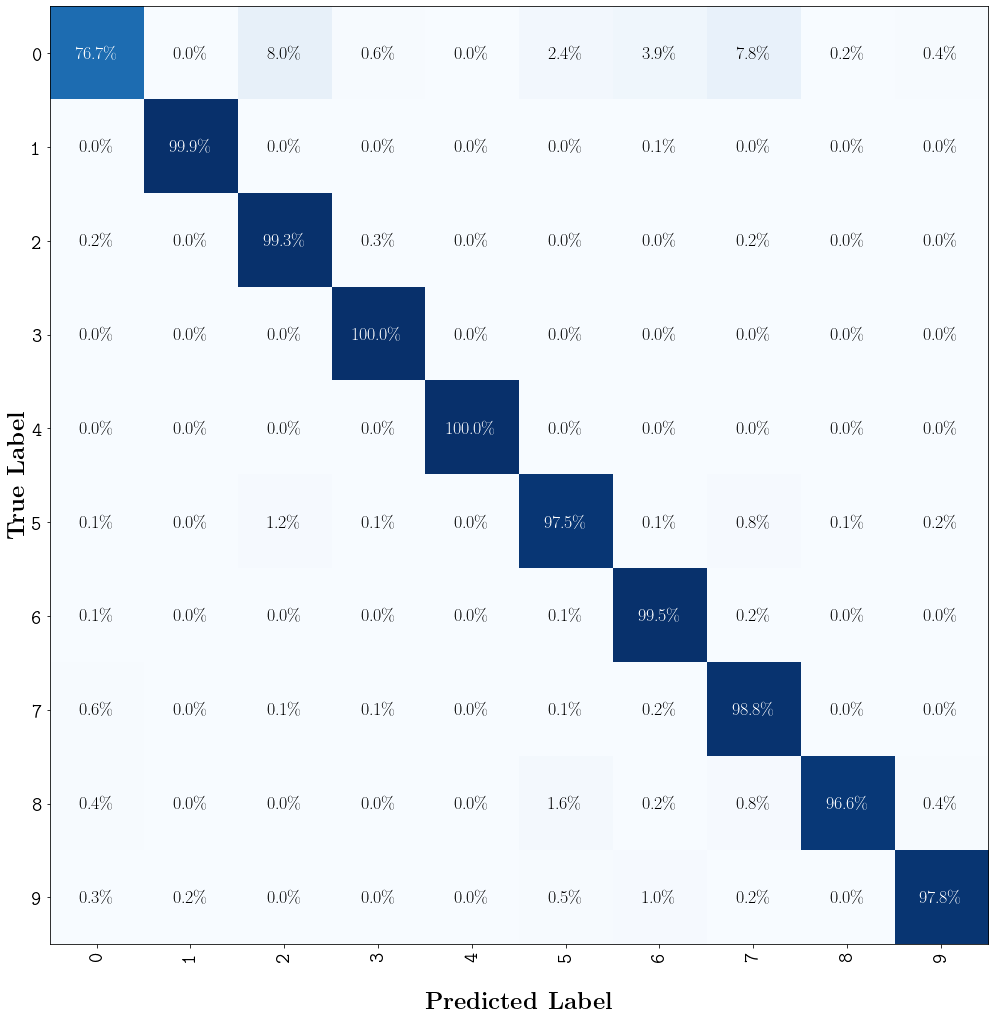

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

conf_matrix = confusion_matrix(all_labels, all_preds)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_percent = conf_matrix_normalized * 100  # Convert to percentages

formatted_classes = [rf'\texttt{{{cls}}}' for cls in dataset.get_class_names()]

plt.rcParams.update({
    "text.usetex": True,
    "font.size": 34,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amsmath}"
})

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=formatted_classes)

im = ax.imshow(conf_matrix_percent, interpolation='nearest', cmap='Blues')

ax.set_xticks(np.arange(len(formatted_classes)))
ax.set_yticks(np.arange(len(formatted_classes)))
ax.set_xticklabels(formatted_classes, fontsize=20)
ax.set_yticklabels(formatted_classes, fontsize=20)

for i in range(conf_matrix_percent.shape[0]):
    for j in range(conf_matrix_percent.shape[1]):
        ax.text(
            j, i,
            f"{conf_matrix_percent[i, j]:.1f}\%",
            ha="center", va="center",
            color="white" if conf_matrix_percent[i, j] > 50 else "black",
            fontsize=18
        )

plt.xlabel(r'\textbf{Predicted Label}', fontsize=24, labelpad=30)
plt.ylabel(r'\textbf{True Label}', fontsize=24)
plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig('CM_VirusMNIST.pdf', format='pdf')

plt.show()
